### Read wind power data from GEFCom2014 and save them to a single csv file

The raw training data are organized in a folder ../data/GEFCom2014/Wind/Task x/Taskx_W_Zone1_10.zip and testing data ../data/GEFCom2014/Wind/Task x/TaskExpVarsx_W_Zone1_10.zip, where x stands for the task number.

Since the final task includes all data (including the final month in "Solution"), we extract the data from this folder.

In [1]:
import os
import pandas as pd
import glob
from natsort import os_sorted
import numpy as np
import matplotlib.pyplot as plt
import operational_analysis as oa

PATH = "/Users/dennis.van_der_meer/Documents/Projects/ConformalPrediction/data/GefCom2014/wind/"

### Start by reading the exogenous data from all the zones for the last month (2013-12) of the data set

Then, read the target variables and join these dataframes on zone ID and time stamp.

In [2]:
# List and sort the csv files of the exogenous data
files = os_sorted(glob.glob(os.path.join(PATH, "*ExpVars*.csv")))

In [3]:
# Read the exogenous data of Task 15 for all 10 zones for the final month
lst = []
for file in files:
    df = pd.read_csv(file, index_col = ["TIMESTAMP", "ZONEID"], parse_dates = True)
    df['WS10'] = np.sqrt(df['U10']**2 + df['V10']**2)
    df['WS100'] = np.sqrt(df['U100']**2 + df['V100']**2)
    df['WD10'] = np.mod(180 + 180/np.pi * np.arctan2(df['V10'], df['U10']), 360)
    df['WD100'] = np.mod(180 + 180/np.pi * np.arctan2(df['V100'], df['U100']), 360)
    df = df.drop(['U10', 'V10', 'U100', 'V100'], axis=1)
    lst.append(df)
df = pd.concat(lst)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
# Read the target data of Task 15 for the final month
file = os.path.join(PATH, "solution15_W.csv")
solutions = pd.read_csv(file, index_col = ["TIMESTAMP", "ZONEID"], parse_dates = True)

In [5]:
# Join the exogenous variables and target data of Task 15 for the final month
tmp = df.merge(solutions, how = 'left', left_index = True, right_index = True)

### The next step is to read the data preceding the previous data, which already has target and exogenous variables combined

However, we still need to convert U and V components to wind speed and wind direction.

In [6]:
# List and sort the csv files of the exogenous and target data
files = os_sorted(glob.glob(os.path.join(PATH, "Task15_*.csv")))

In [7]:
# Read the exogenous data of Task 15 for all 10 zones for the final month
lst = []
for file in files:
    df = pd.read_csv(file, index_col = ["TIMESTAMP", "ZONEID"], parse_dates = True)
    df['WS10'] = np.sqrt(df['U10']**2 + df['V10']**2)
    df['WS100'] = np.sqrt(df['U100']**2 + df['V100']**2)
    df['WD10'] = np.mod(180 + 180/np.pi * np.arctan2(df['V10'], df['U10']), 360)
    df['WD100'] = np.mod(180 + 180/np.pi * np.arctan2(df['V100'], df['U100']), 360)
    df = df.drop(['U10', 'V10', 'U100', 'V100'], axis=1)
    lst.append(df)
df = pd.concat(lst)

### Now it is possible to concatenate the data frames so that there's a continuous data set for 2012-2013

Note that there are missing target values (although not that many) so there's also groupwise linear interpolation to deal with these.

In [12]:
dat = pd.concat([df, tmp])
print(dat.isna().sum())
dat = dat.groupby('ZONEID').apply(lambda group: group.interpolate(method = 'linear', limit_direction = 'both'))
print(dat.isna().sum())

TARGETVAR    175
WS10           0
WS100          0
WD10           0
WD100          0
dtype: int64
TARGETVAR    0
WS10         0
WS100        0
WD10         0
WD100        0
dtype: int64


### Let's plot the wind power versus the wind speed to see if there are no obvious anomalies in the data that we might want to filter out

/opt/anaconda3/envs/conformalprediction/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='WS100', ylabel='TARGETVAR'>

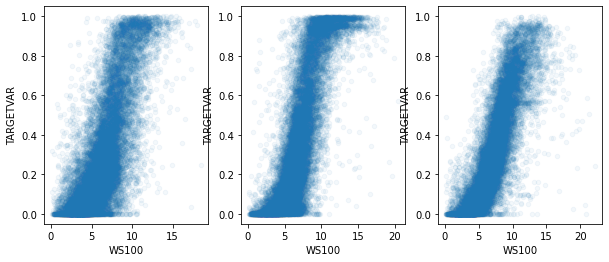

In [13]:
fig, ax = plt.subplots(ncols=3, figsize=(10,4))

dat.xs(1, level = 1, drop_level = False).plot.scatter(x = 'WS100', y = 'TARGETVAR', ax=ax[0], alpha = 0.05)
dat.xs(4, level = 1, drop_level = False).plot.scatter(x = 'WS100', y = 'TARGETVAR', ax=ax[1], alpha = 0.05)
dat.xs(7, level = 1, drop_level = False).plot.scatter(x = 'WS100', y = 'TARGETVAR', ax=ax[2], alpha = 0.05)

### It doesn't seem like there are obvious outliers but we can use [OpenOA](https://github.com/NREL/OpenOA) to flag suspicious data and potentially filter them out.